In this blog post, I will use the `DecisionTreeClassifier` module to analyze racial bias in the PUMS dataset of Texas in 2018.

In [149]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "TX"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000026,7,1,5000,3,48,1013097,29,21,...,29,4,5,54,27,52,28,29,52,29
1,P,2018GQ0000057,7,1,6601,3,48,1013097,16,19,...,33,3,18,16,32,3,18,16,2,2
2,P,2018GQ0000070,7,1,4302,3,48,1013097,64,24,...,14,64,110,62,14,15,64,64,13,67
3,P,2018GQ0000079,7,1,700,3,48,1013097,260,20,...,57,451,261,272,59,477,261,258,480,56
4,P,2018GQ0000082,7,1,900,3,48,1013097,12,31,...,10,3,11,22,12,20,1,12,21,1


In [150]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,21,16.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,2,1.0
1,19,16.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0
2,24,12.0,5,16,1,NaN,1,1.0,4.0,1,1,2,2,1.0,1,2,6.0
3,20,16.0,5,17,2,NaN,1,1.0,3.0,1,1,2,2,2.0,2,1,1.0
4,31,17.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,1,1,1.0


In [151]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [152]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [154]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [155]:
print('1. There are ' + str(len(df)) + ' individuals in this survey.')
print('2. Of those individuals, ' + str(len(df[df['label'] == 1])) + ' are employed.')

1. There are 214480 individuals in this survey.
2. Of those individuals, 96805 are employed.


In [156]:
print('3. The number of individuals in each racial group is: \n' + str(df.groupby('group')['label'].aggregate(len)))

3. The number of individuals in each racial group is: 
group
1    165969
2     20614
3       836
4        14
5       401
6     10141
7       158
8     10544
9      5803
Name: label, dtype: int64


In [157]:
print('4. The proportion of employed individuals in each racial group is: \n' + str(df[df['label'] == 1].groupby('group')['label'].aggregate(len)/df.groupby('group')['label'].aggregate(len)))

4. The proportion of employed individuals in each racial group is: 
group
1    0.455242
2    0.416756
3    0.431818
4    0.357143
5    0.461347
6    0.499359
7    0.430380
8    0.466711
9    0.353955
Name: label, dtype: float64


In [158]:
print('5.1. The proportion of employed male individuals in each racial group is: \n' + str(df[df['SEX'] == 1][df['label'] == 1].groupby('group')['label'].aggregate(len)/df[df['SEX'] == 1].groupby('group')['label'].aggregate(len)))

5.1. The proportion of employed male individuals in each racial group is: 
group
1    0.502327
2    0.396673
3    0.474178
4    0.250000
5    0.488263
6    0.553741
7    0.428571
8    0.529160
9    0.371400
Name: label, dtype: float64


C:\Users\ledtr\AppData\Local\Temp\ipykernel_5008\3156142459.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('5.1. The proportion of employed male individuals in each racial group is: \n' + str(df[df['SEX'] == 1][df['label'] == 1].groupby('group')['label'].aggregate(len)/df[df['SEX'] == 1].groupby('group')['label'].aggregate(len)))


In [159]:
print('5.2. The proportion of employed female individuals in each racial group is: \n' + str(df[df['SEX'] == 2][df['label'] == 1].groupby('group')['label'].aggregate(len)/df[df['SEX'] == 2].groupby('group')['label'].aggregate(len)))

5.2. The proportion of employed female individuals in each racial group is: 
group
1    0.410106
2    0.435596
3    0.387805
4    0.500000
5    0.430851
6    0.447318
7    0.432836
8    0.401550
9    0.335905
Name: label, dtype: float64


C:\Users\ledtr\AppData\Local\Temp\ipykernel_5008\266627361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('5.2. The proportion of employed female individuals in each racial group is: \n' + str(df[df['SEX'] == 2][df['label'] == 1].groupby('group')['label'].aggregate(len)/df[df['SEX'] == 2].groupby('group')['label'].aggregate(len)))


Except for groups 2, 4 and 7, the other racial groups have a higher proportion of employed men than women.

Now we will train our model. I'm using the `DecisionTreeClassifier` model. Below is my code to see which maximum depth of the tree gives the most accuracy. The cross-validation is only done on the training data.

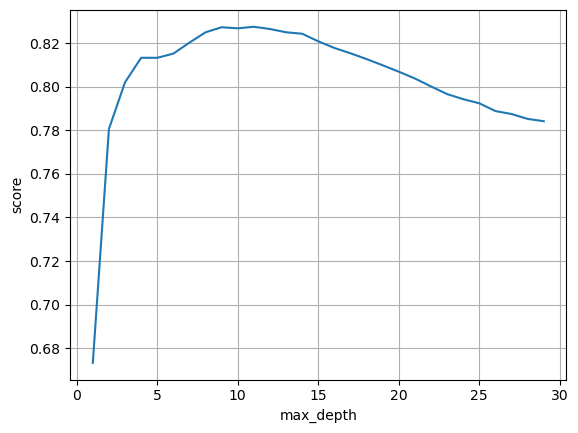

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cross_train, cross_test, crossy_train, crossy_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
score_i = []

for i in range(1, 30):
    model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = i))
    model.fit(cross_train, crossy_train)
    y_hat = model.predict(cross_test)
    score = (y_hat == crossy_test).mean()
    score_i.append(score)

plt.plot(np.arange(1, 30), score_i)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.grid()

It seems that `max_depth = 9` is our optimal tree depth. We will now test this model on test data.

In [164]:
model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = 9))
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
score = (y_hat == y_test).mean()
print('1. The overall accuracy of the model is ' + str(score.round(4)) + '.')

from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test, y_hat, normalize='true')
TN = C[0][0]
FP = C[0][1]
FN = C[1][0]
TP = C[1][1]
PPV = TP/(TP+FP)
print('2. The overall positive predictive value is ' + str(PPV.round(4)) + '.')
print('3. The overall false negative rate is ' + str(FN.round(4)) + ' and false positive rate is ' + str(FP.round(4)) + '.')

1. The overall accuracy of the model is 0.8237.
2. The overall positive predictive value is 0.8045.
3. The overall false negative rate is 0.1361 and false positive rate is 0.2099.


In [165]:
sub_acc = []
sub_PPV = []
sub_FNR = []
sub_FPR = []

for i in range(1,10):
    y_hat = model.predict(X_test)
    score = (y_hat[group_test == i] == y_test[group_test == i]).mean()
    sub_acc.append(score)
    C = confusion_matrix(y_test[group_test == i], y_hat[group_test == i], normalize='true')
    TN = C[0][0]
    FP = C[0][1]
    FN = C[1][0]
    TP = C[1][1]
    PPV = TP/(TP+FP)
    sub_PPV.append(PPV)
    sub_FNR.append(FN)
    sub_FPR.append(FP)

Now we will look at these numbers in each subgroup. The information is displayed in the following graphs.

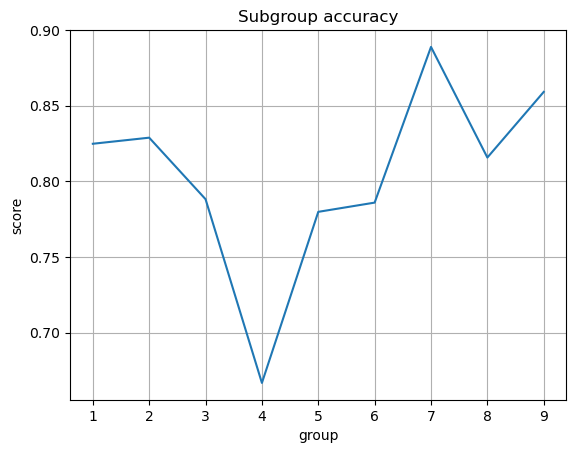

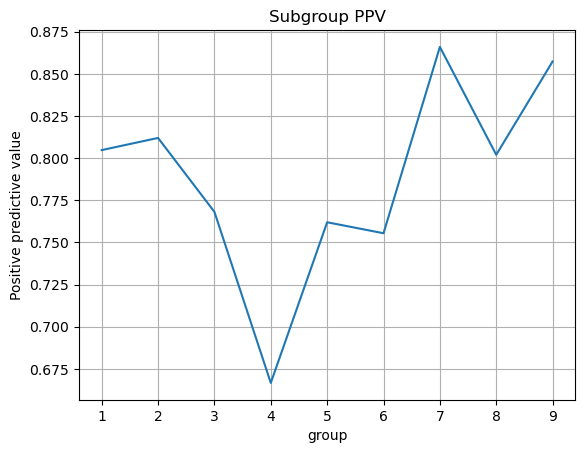

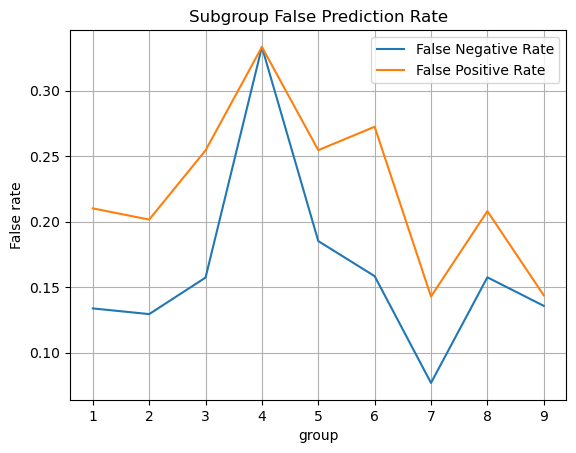

In [166]:
fig1, ax1 = plt.subplots()
hello = np.arange(1,10)
ax1.plot(hello, sub_acc)
ax1.set_xlabel('group')
ax1.set_ylabel('score')
ax1.set_title('Subgroup accuracy')
ax1.grid()

fig2, ax2 = plt.subplots()
ax2.plot(hello, sub_PPV)
ax2.set_xlabel('group')
ax2.set_ylabel('Positive predictive value')
ax2.set_title('Subgroup PPV')
ax2.grid()

fig3, ax3 = plt.subplots()
ax3.plot(hello, sub_FNR, label = 'False Negative Rate')
ax3.plot(hello, sub_FPR, label = 'False Positive Rate')
ax3.set_xlabel('group')
ax3.set_ylabel('False rate')
ax3.set_title('Subgroup False Prediction Rate')
ax3.legend()
ax3.grid()

plt.show()

This model is approximately calibrated. If we exclude group 4, which has a small sample size of 14 individuals, the positive predictive value for each group is close to the overall PPV. It is the same case for the FNR and FPR, which means that this model also satisfies approximate error rate balance. This means that our model has the same prevalence for all groups, which means that this is an amazing model!

# Conclusion

1. This model can be used by job referrals websites such as LinkedIn to advertise to potentially unemployed people. It can also be used by car insurance companies to advertise to potentially employed people, who may own a car to commute to work. Or it can be used by apartment complexes to advertise to employed people.
2. I think that if this model is used in a governmental setting, the model can predict the employability of a person based on their features excluding race. This can be used to decide whether a person is eligible for a loan (if they can pay back the loan by working at a job), whether they can rent a place in a certain area (expensive areas require a stable and supple income).
3. Based on my audit, my model does not have any problematic bias.
4. A problem with my model is that it cannot accurately predict for racial groups that have too few individuals.